In [2]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
URM_all = getURM_all()
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [3]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([32, 20,  3, ...,  3, 13, 43], dtype=int32), (12638,))

In [21]:
block_size = int(len(profile_length)*0.2)
block_size

2527

In [22]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 5):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 2527, average p.len 1.23, median 1.0, min 0, max 3
Group 1, #users in group 2527, average p.len 4.91, median 5.0, min 3, max 8
Group 2, #users in group 2527, average p.len 11.76, median 11.0, min 8, max 17
Group 3, #users in group 2527, average p.len 25.37, median 25.0, min 17, max 37
Group 4, #users in group 2527, average p.len 77.24, median 61.0, min 37, max 465


In [23]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import (MatrixFactorization_BPR_Cython,
                                                                            MatrixFactorization_AsySVD_Cython)
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   "SLIMELASTIC": SLIMElasticNetRecommender,
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].load_model("result_experiments/", "TopPopRecommender_best_model.zip")
recommender_object_dict["SLIMELASTIC"].load_model("result_experiments/", "SLIMElasticNetRecommender_best_model.zip")
recommender_object_dict["PureSVD"].load_model("result_experiments/", "PureSVDRecommender_best_model.zip")
recommender_object_dict["NMF"].fit()
recommender_object_dict["P3alpha"].load_model("result_experiments/", "P3alphaRecommender_best_model.zip")
recommender_object_dict["RP3beta"].load_model("result_experiments/", "RP3betaRecommender_best_model.zip")
recommender_object_dict["UserKNNCF"].load_model("result_experiments/", "UserKNNCFRecommender_cosine_best_model.zip")
recommender_object_dict["ItemKNNCF"].load_model("result_experiments/", "ItemKNNCFRecommender_cosine_best_model.zip")

TopPopRecommender: URM Detected 446 ( 3.5%) users with no interactions.
TopPopRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 446 ( 3.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 446 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
P3alphaRecommender: URM Detected 446 ( 3.5%) users with no interactions.
P3alphaRecommender: URM Detected 342 ( 1.5%) items with no interactions.
RP3betaRecommender: URM Detected 446 ( 3.5%) users with no interactions.
RP3betaRecommender: URM Detected 342 ( 1.5%) items with no interactions.
PureSVDRecommender: URM Detected 446 ( 3.5%) users with no interactions.
PureSVDRecommender: URM Detected 342 ( 1.5%) items with no interactions.
NMFRecommender: URM Detected 446 ( 3.5%) users with no interactions.
NMFRecommender: URM Detected 342 ( 1.5%) items wi

/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:619: RuntimeWarning: overflow encountered in divide
  numerator /= denominator
/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:626: RuntimeWarning: invalid value encountered in multiply
  W *= delta_W
/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMFRecommender: Computing NMF decomposition... done in 23.17 sec
P3alphaRecommender: Loading model from file 'result_experiments/P3alphaRecommender_best_model.zip'
P3alphaRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3betaRecommender_best_model.zip'
RP3betaRecommender: Loading complete
UserKNNCFRecommender: Loading model from file 'result_experiments/UserKNNCFRecommender_cosine_best_model.zip'
UserKNNCFRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender_cosine_best_model.zip'
ItemKNNCFRecommender: Loading complete


In [25]:
from Evaluation.Evaluator import EvaluatorHoldout

cutoff = 10

for group_id in range(0, 5):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 2527, average p.len 1.23, median 1.0, min 0, max 3
EvaluatorHoldout: Ignoring 2190 (17.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 10111 Users
EvaluatorHoldout: Processed 1110 (100.0%) in 0.49 sec. Users per second: 2284
EvaluatorHoldout: Processed 1110 (100.0%) in 0.47 sec. Users per second: 2383
EvaluatorHoldout: Processed 1110 (100.0%) in 0.32 sec. Users per second: 3455
EvaluatorHoldout: Processed 1110 (100.0%) in 0.30 sec. Users per second: 3671
EvaluatorHoldout: Processed 1110 (100.0%) in 0.28 sec. Users per second: 4015
EvaluatorHoldout: Processed 1110 (100.0%) in 0.49 sec. Users per second: 2259
EvaluatorHoldout: Processed 1110 (100.0%) in 0.48 sec. Users per second: 2313
EvaluatorHoldout: Processed 1110 (100.0%) in 0.33 sec. Users per second: 3326
Group 1, #users in group 2527, average p.len 4.91, median 5.0, min 3, max 8
EvaluatorHoldout: Ignoring 2190 (17.3%) Users that have less than 1 test interactions
EvaluatorHold

/Users/alessandro/RecSys-2023-polimi/Evaluation/metrics.py:513: RuntimeWarning: invalid value encountered in divide
  gini_diversity = 2*np.sum((n_items + 1 - index)/(n_items+1) * recommended_counter_sorted/np.sum(recommended_counter_sorted))


EvaluatorHoldout: Processed 2521 (100.0%) in 0.92 sec. Users per second: 2746
Group 4, #users in group 2527, average p.len 77.24, median 61.0, min 37, max 465
EvaluatorHoldout: Ignoring 2190 (17.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 10111 Users
EvaluatorHoldout: Processed 2527 (100.0%) in 0.92 sec. Users per second: 2735
EvaluatorHoldout: Processed 2527 (100.0%) in 1.39 sec. Users per second: 1812
EvaluatorHoldout: Processed 2527 (100.0%) in 1.74 sec. Users per second: 1456
EvaluatorHoldout: Processed 2527 (100.0%) in 1.49 sec. Users per second: 1692
EvaluatorHoldout: Processed 2527 (100.0%) in 0.59 sec. Users per second: 4302
EvaluatorHoldout: Processed 2527 (100.0%) in 1.04 sec. Users per second: 2426
EvaluatorHoldout: Processed 2527 (100.0%) in 0.48 sec. Users per second: 5237


/Users/alessandro/RecSys-2023-polimi/Evaluation/metrics.py:513: RuntimeWarning: invalid value encountered in divide
  gini_diversity = 2*np.sum((n_items + 1 - index)/(n_items+1) * recommended_counter_sorted/np.sum(recommended_counter_sorted))


EvaluatorHoldout: Processed 2527 (100.0%) in 1.07 sec. Users per second: 2368


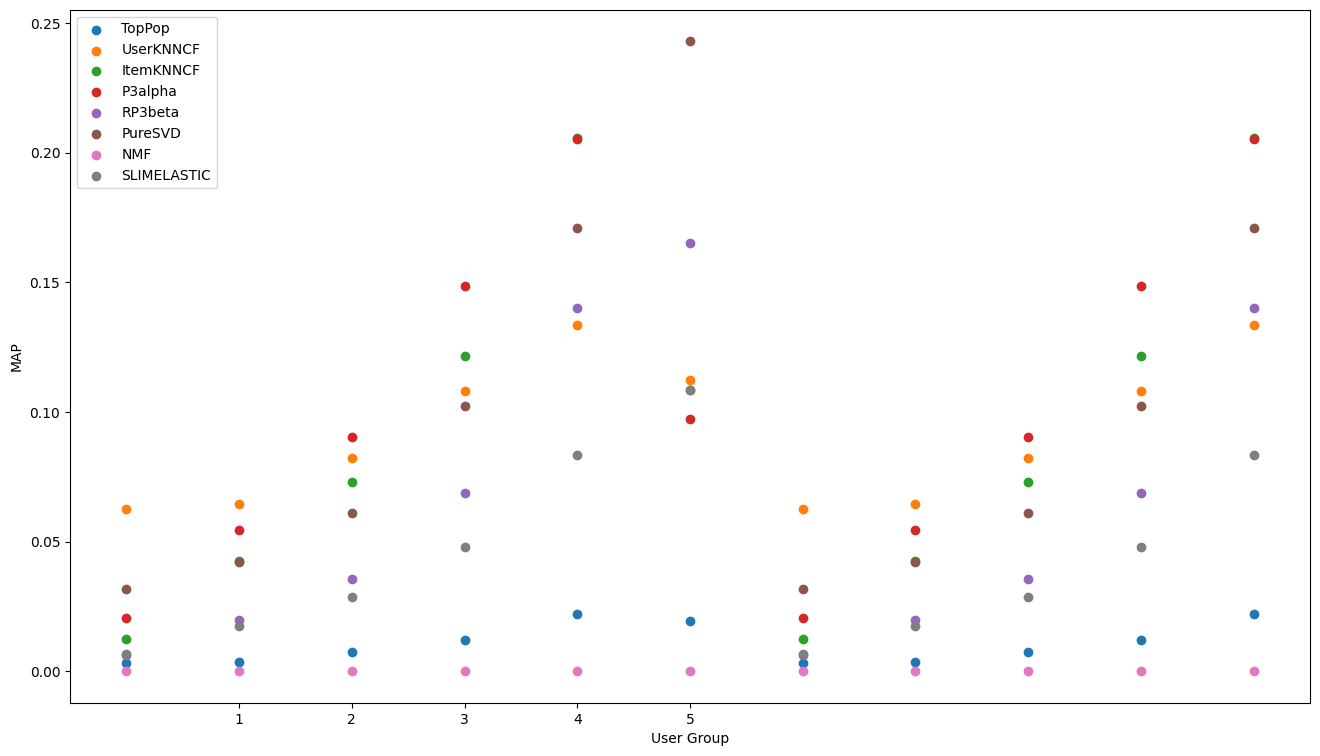

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [5]:
item_recommender = ItemKNNCFRecommender(URM_train=URM_validation)
item_recommender.load_model("result_experiments/", "ItemKNNCFRecommender_cosine_best_model.zip")

ItemKNNCFRecommender: URM Detected 2612 (20.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 5701 (25.7%) items with no interactions.
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender_cosine_best_model.zip'
ItemKNNCFRecommender: Loading complete


In [6]:
slim_recommender = SLIMElasticNetRecommender(URM_train=URM_validation)
slim_recommender.load_model("result_experiments/", "SLIMElasticNetRecommender_best_model.zip")

SLIMElasticNetRecommender: URM Detected 2612 (20.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 5701 (25.7%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIMElasticNetRecommender_best_model.zip'
SLIMElasticNetRecommender: Loading complete


In [13]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
recommender = PureSVDRecommender(URM_train=URM_all)
recommender.load_model("result_experiments/", "PureSVDRecommender_best_model.zip")

PureSVDRecommender: Loading model from file 'result_experiments/PureSVDRecommender_best_model.zip'
PureSVDRecommender: Loading complete


In [14]:
from Recommenders.NonPersonalizedRecommender import TopPop
top_recommender = TopPop(URM_all)
top_recommender.fit()

In [ ]:
generateSubmission(recommender, top_recommender)